# Remove instrument response

This notebook will explore different ways to remove the instrument response from the data

In [1]:
%matplotlib widget

import numpy as np
from scipy import signal as sps

from mt_metadata.timeseries.filters import PoleZeroFilter, FrequencyResponseTableFilter
from mth5.timeseries import ChannelTS
from mth5.timeseries import ts_filters
from mth5.utils.exceptions import MTTSError

from matplotlib import pyplot as plt

window = False

2021-12-01 17:31:15,182 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\Documents\GitHub\mth5\logs\mth5_debug.log


## Create a channel

In [2]:
c = ChannelTS()
c.sample_rate = 256

n_samples = 50000
t = np.arange(n_samples) * c.sample_interval
c.ts = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 2, 20), np.random.rand(20))], axis=0)

### Add a filter as an instrument response

In [3]:
#pz = PoleZeroFilter(units_in="volts", units_out="nanotesla", name="instrument_response")
#pz.poles = [(-6.283185+10.882477j), (-6.283185-10.882477j), (-12.566371+0j)]
#pz.zeros = []
#pz.normalization_factor = 2002.269 

#c.channel_response_filter.filters_list.append(pz)

In [4]:
fap = FrequencyResponseTableFilter(units_in="volts", units_out="nanotesla", name="example_fap")

fap.frequencies = [
    1.95312000e-03,   2.76214000e-03,   3.90625000e-03,
     5.52427000e-03,   7.81250000e-03,   1.10485000e-02,
     1.56250000e-02,   2.20971000e-02,   3.12500000e-02,
     4.41942000e-02,   6.25000000e-02,   8.83883000e-02,
     1.25000000e-01,   1.76780000e-01,   2.50000000e-01,
     3.53550000e-01,   5.00000000e-01,   7.07110000e-01,
     1.00000000e+00,   1.41420000e+00,   2.00000000e+00,
     2.82840000e+00,   4.00000000e+00,   5.65690000e+00,
     8.00000000e+00,   1.13140000e+01,   1.60000000e+01,
     2.26270000e+01,   3.20000000e+01,   4.52550000e+01,
     6.40000000e+01,   9.05100000e+01,   1.28000000e+02,
     1.81020000e+02,   2.56000000e+02,   3.62040000e+02,
     5.12000000e+02,   7.24080000e+02,   1.02400000e+03,
     1.44820000e+03,   2.04800000e+03,   2.89630000e+03,
     4.09600000e+03,   5.79260000e+03,   8.19200000e+03,
     1.15850000e+04]

fap.amplitudes = [
    1.59009000e-03,   3.07497000e-03,   5.52793000e-03,
    9.47448000e-03,   1.54565000e-02,   2.49498000e-02,
    3.96462000e-02,   7.87192000e-02,   1.57134000e-01,
    3.09639000e-01,   5.94224000e-01,   1.12698000e+00,
    2.01092000e+00,   3.33953000e+00,   5.00280000e+00,
    6.62396000e+00,   7.97545000e+00,   8.82872000e+00,
    9.36883000e+00,   9.64102000e+00,   9.79664000e+00,
    9.87183000e+00,   9.90666000e+00,   9.92845000e+00,
    9.93559000e+00,   9.93982000e+00,   9.94300000e+00,
    9.93546000e+00,   9.93002000e+00,   9.90873000e+00,
    9.86383000e+00,   9.78129000e+00,   9.61814000e+00,
    9.26461000e+00,   8.60175000e+00,   7.18337000e+00,
    4.46123000e+00,  -8.72600000e-01,  -5.15684000e+00,
    -2.95111000e+00,  -9.28512000e-01,  -2.49850000e-01,
    -5.75682000e-02,  -1.34293000e-02,  -1.02708000e-03,
    1.09577000e-03]

fap.phases = [
    7.60824000e-02,   1.09174000e-01,   1.56106000e-01,
    2.22371000e-01,   3.12020000e-01,   4.41080000e-01,
    6.23548000e-01,   8.77188000e-01,   1.23360000e+00,
    1.71519000e+00,   2.35172000e+00,   3.13360000e+00,
    3.98940000e+00,   4.67269000e+00,   4.96593000e+00,
    4.65875000e+00,   3.95441000e+00,   3.11098000e+00,
    2.30960000e+00,   1.68210000e+00,   1.17928000e+00,
    8.20015000e-01,   5.36474000e-01,   3.26955000e-01,
    1.48051000e-01,  -8.24275000e-03,  -1.66064000e-01,
    -3.48852000e-01,  -5.66625000e-01,  -8.62435000e-01,
    -1.25347000e+00,  -1.81065000e+00,  -2.55245000e+00,
    -3.61512000e+00,  -5.00185000e+00,  -6.86158000e+00,
    -8.78698000e+00,  -9.08920000e+00,  -4.22925000e+00,
     2.15533000e-01,   6.00661000e-01,   3.12368000e-01,
     1.31660000e-01,   5.01553000e-02,   1.87239000e-02,
     6.68243000e-03]

c.channel_response_filter.filters_list.append(fap)

## Estimate the response and remove
This will be done in the frequency domain, so there are some tricks that we will need to use to be sure that the calibrated response is "clean"

1. Pad the data to a power of 2 to make the FFT more efficient
2. Apply a window ?
3. Compute frequencies, the complex response of the filters, and FFT.  Here we will use rfft which computes uses the real signal and computes one side of the symmetric spectrum and is quicker
4. Compute iFFT and trim to the original number of samples
5. Bandpass if desired to remove effects of the response filter, this is important for broadband instruments 

In [12]:
# 1
ts_npow = ts_filters.zero_pad(c.ts)
print(ts_npow.size)

# 2
if window:
    ts_npow *= sps.windows.nuttall(ts_npow.size)

# 3
f = np.fft.rfftfreq(ts_npow.size, c.sample_interval)
ts_fft = np.fft.rfft(ts_npow)
cr = c.channel_response_filter.complex_response(f)
ts_remove_response = ts_fft / cr

# 4
ts_calibrated = np.fft.irfft(ts_remove_response)

# 5
highcut = 100
lowcut = .05
order = 3
ts_bp = ts_filters.butter_bandpass_filter(ts_calibrated, lowcut, highcut, c.sample_rate, order=order)
bp = ts_filters.butter_bandpass(lowcut, highcut, c.sample_rate, order=order)

2021-12-01 17:32:12,884 [line 192] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


65536


## Plot some results

C:\Users\jpeacock\AppData\Local\Temp\1/ipykernel_23108/2839787752.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  fig.clf()
C:\Users\jpeacock\AppData\Local\Temp\1/ipykernel_23108/2839787752.py:29: RuntimeWarning: divide by zero encountered in log10
  ax6.semilogx((c.sample_rate * 0.5 / np.pi) * w, 20*np.log10(abs(h)))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
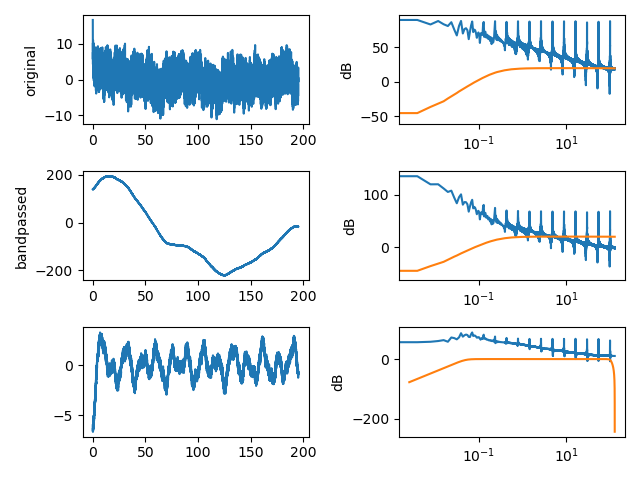

In [13]:
fig = plt.figure(1)
fig.clf()

ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(t, c.ts)
ax1.set_ylabel("original")

ax2 = fig.add_subplot(3, 2, 2)
ax2.semilogx(f, 20*np.log10(np.abs(ts_fft))) 
ax2.semilogx(f, 20*np.log10(np.abs(cr)))
ax2.set_ylabel("dB")

ax3 = fig.add_subplot(3, 2, 3, sharex=ax1)
ax3.plot(t, ts_calibrated[0:n_samples])
ax3.set_ylabel("calibrated")

ax4 = fig.add_subplot(3, 2, 4, sharex=ax2)
ax4.semilogx(f, 20*np.log10(np.abs(np.fft.rfft(ts_calibrated))))
ax4.semilogx(f, 20*np.log10(np.abs(cr)))
ax4.set_ylabel("dB")

ax5 = fig.add_subplot(3, 2, 5, sharex=ax1)
ax5.plot(t, ts_bp[0:n_samples])
ax3.set_ylabel("bandpassed")

ax6 = fig.add_subplot(3, 2, 6, sharex=ax2)
ax6.semilogx(f, 20*np.log10(np.abs(np.fft.rfft(ts_bp))))
w, h = sps.sosfreqz(bp, worN=n_samples)
ax6.semilogx((c.sample_rate * 0.5 / np.pi) * w, 20*np.log10(abs(h)))
ax6.set_ylabel("dB")

fig.tight_layout()

fig.canvas.toolbar_visible = True
fig.canvas.resizable = True
display(fig.canvas)

In [7]:
ts_bp.shape

(65536,)

In [8]:
np.log10(128)


2.1072099696478683